In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import os
import sys
sys.path.append(f'{os.environ["HOME"]}/Projects/planckClusters/catalogs')
from load_catalogs import load_PSZcatalog
from astropy.table import Table, Column
from scipy.stats import ks_2samp
from scipy.stats import ksone
import emcee

import aplpy
import matplotlib.patheffects as pe
from astropy.io.fits import getheader

In [2]:
def beta_model(So, r, rc, beta):
    ''' Beta model with 3 parameters. 
    So -- normalization
    rc -- core radius
    beta -- powerlaw slope

    returns the flux (Cnts/pixel)

    '''
    
    return So * ( 1.0 + (r / rc)**2)**(-3.0 * beta + 0.5)

def chi2(model, y, y_err):
    '''Chi error. We are going to square this to make it the chi2 error.'''
    return np.sum(((model - y) / y_err)**2)

def like(theta, x, y, yerr):
    So, rc, beta, bg = theta
    model = beta_model(So, x, rc, beta) + bg
    #return -0.5 * np.sum(np.log(2 * np.pi * yerr) + (y - model)**2 / yerr)
    return -chi2(model, y, yerr)

def prior(theta):
    So, rc, beta, bg = theta
    if So < 0:
        return -np.inf
    elif rc < 0 or rc > 10:
        return -np.inf
    elif beta < 0 or beta > 3: 
        return -np.inf
    elif bg < 0 or bg > 1:
        return -np.inf
    else:
        return 0.0

def prob(theta, x, y, yerr):
    lp = prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + like(theta, x, y, yerr)

def fit_radprof(name, outpath, src=1, ax=None):
    # swift pixelscale in degrees
    pixsc =  6.548089E-04 * 3600

    i = src
    if os.path.isfile(f'{outpath}/{name}/{name}_vtp_{i}.radprof'):
        data = Table.read(f'{outpath}/{name}/{name}_vtp_{i}.radprof', format='ascii', header_start=2)

    # x-axis, in arcminutes
    x = (data['r1'] + data['r2'])/ 2. / 60. * pixsc

    # this is the parameter fitting
    ndim = 4  # number of parameters in the model
    nwalkers = 100  # number of MCMC walkers
    nburn = 100  # "burn-in" period to let chains stabilize
    nsteps = 500  # number of MCMC steps to take

    pos = [np.array([0.001, 1., 1., 0.001]) + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, prob, args=(x, data['sb'], data['sb_err']))
    sampler.run_mcmc(pos, nsteps)
    emcee_trace = sampler.get_chain(discard=nburn, thin=15, flat=True)

    # plot the result
    if not ax:
        fignum = np.random.randint(1, 1000)
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6.5, 5), num=fignum)
    # data
    ax.errorbar(x, data['sb'], yerr=data['sb_err'], fmt='.', label='data', zorder=0)
    # plot the range of the models
    a, b, c, d = emcee_trace.T
    bmodel = beta_model(a[:, None], x, b[:, None], c[:, None]) + d[:, None]

    mu = bmodel.mean(0)                                                                 
    sig = bmodel.std(0)  # 2sigma confidence

    ax.fill_between(x, mu - sig, mu + sig, color='k', alpha=0.5, zorder=2)

#         for So, rc, beta, bg in emcee_trace[np.random.randint(len(emcee_trace), size=100)]:
#             ax.plot(x, beta_model(So, x, rc, beta) + bg, color='k', alpha=0.1)
    ylims = ax.get_ylim()

    #fit -- median (and error) values
    So, rc, beta, bg = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                         zip(*np.percentile(emcee_trace, [16, 50, 84], axis=0)))
    ax.plot(x, beta_model(So[0], x, rc[0], beta[0]) + bg[0], color='#A60628', label=r'$\beta$ + bg', zorder=2)
#     ax.plot(x, beta_model(So[0], x, rc[0], beta[0]), label=r'$\beta$', zorder=1)

    ax.plot(x, data['psfsb'] + bg[0], ls='--', label='PSF', color='#E24A33', zorder=1)

    # rc and bg lines
    ax.axhline(bg[0], label='bkg', zorder=0, lw=1)
#     ax.axvline(rc[0], zorder=0, lw=1, label='$r_c$')

    ax.semilogy()

    if ylims[0] < 1e-5:
#         ax.text(rc[0] + 0.1, 2e-5, f"$r_c$ = {rc[0]:.2f}'", rotation='vertical', ha='left')
        ax.set_ylim(1e-5, ylims[1])
    else:
#         ax.text(rc[0] + 0.1, ylims[0], f"$_c$ = {rc[0]:.2f}'", rotation='vertical', ha='left')
        ax.set_ylim(ylims)
    ax.set_xlabel('Radius [arcmin]')
    ax.set_ylabel('Flux [cnts/s/$arcmin^2$]')
#     ax.legend(loc='upper right', ncol=2)
    
    return ax

In [3]:
def ks_critical_value(alpha, n_trials):
    ''' returns the critial value for a given alpha and number of trials'''
    return ksone.ppf(1-alpha/2, n_trials)

def ks_alpha(cv, n_trials):
    ''' returns the alpha for a given critical value and number of trials'''
    return ksone.sf(cv, n_trials) * 2

def test_ks_cv(alphas=None, n_trials=None):

    if not n_trials:
        n_trials = range(5,15)
    if not alphas:
        alphas = [0.5, 0.1, 0.05, 0.02, 0.01]

    if isinstance(n_trials, int) or isinstance(n_trials, float):
        n_trials = range(n_trials - 2, n_trials + 2)
        
    # Print table headers
    print('{:<6}|{:<6} Level of significance, alpha'.format(' ', ' '))
    print('{:<6}|{:>8} {:>8} {:>8} {:>8} {:>8}'.format(*['Trials'] + alphas))
    print('-' * 42)
    # Print critical values for each n_trials x alpha combination
    for t in n_trials:
        print('{:6d}|{:>8.5f} {:>8.5f} {:>8.5f} {:>8.5f} {:>8.5f}'
              .format(*[t] + [ks_critical_value(a, t) for a in alphas]))

def ks_test_sources(name, outpath, plotting=False, ax=None):
    
    # detections
    if not os.path.isfile(f'{outpath}/{name}/{name}_vtp.detect'):
        return
    else:
        srcs = f'{outpath}/{name}/{name}_vtp.detect'

    # mcmc fit data
    if not os.path.isfile(f'{outpath}/{name}/{name}_mcmcfits.txt'):
        return
    else:
        mcmcfits = f'{outpath}/{name}/{name}_mcmcfits.txt'
        fit = Table.read(mcmcfits, format='ascii', header_start=0)
                
    # now we need to read the individual detections
    detects = Table.read(srcs, hdu=1)

    # add a column for classifications!
    try:   
        # add the columns to the detection catalog
        detects.add_column(Column(data=np.ones(len(detects)) * -1, name='Extended', dtype='>i8'))
    except ValueError:
        pass
    
    if plotting and not ax:
        fignum = np.random.randint(1, 1000)
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6.5, 5), num=fignum)
    
    # loop over the sources -- only the first 3
    for indx, i in enumerate(detects['INDEX']):
        if os.path.isfile(f'{outpath}/{name}/{name}_vtp_{i}.radprof'):
            data = Table.read(f'{outpath}/{name}/{name}_vtp_{i}.radprof', format='ascii', header_start=2)
        else:
            continue
    
        # where is it in the mcmc file?
        loc = fit['ID'] == i
        if not loc.any(): # we didn't fit that one with mcmc
            continue
        bkg = fit['bg_50'][loc] # cnts/s/arcmin2

        # convert to cnts/s
        pixscale = 2.36 # arcs/pix
        bkg *= pixscale**2 / 60**2 # cnts/s/arcmin2 * arcmin2/pix2
        source_exp = data['x']/data['y'] - bkg * data['w'] # cnts/s - cnts/s/pix2 * pix2
        psf_exp = data['psf'] / data['y'] # cnts/s
        
        # cummulative distributions
        source_cum = np.cumsum(source_exp)
        psf_cum = np.cumsum(psf_exp)
        
        # how far out do we want to go?
        bins = 12
        
        # normalized
        source_cum_n = source_cum / source_cum[bins - 1]
        psf_cum_n = psf_cum / psf_cum[bins - 1]
                   
        # plotting
        if plotting:
            # x-axis, in arcminutes
            x = (data['r1'] + data['r2'])/ 2. / 60. * pixscale
            ax.plot(x[:bins], source_cum_n[:bins], label=i)
    
    if plotting:
        ax.plot(x[:bins], psf_cum_n[:bins], color='#E24A33', ls='--', label='PSF')
        plt.legend()

In [4]:
outpath = '../data_full_new'
name = 'PSZ1_G221.64-58.20'

<IPython.core.display.Javascript object>


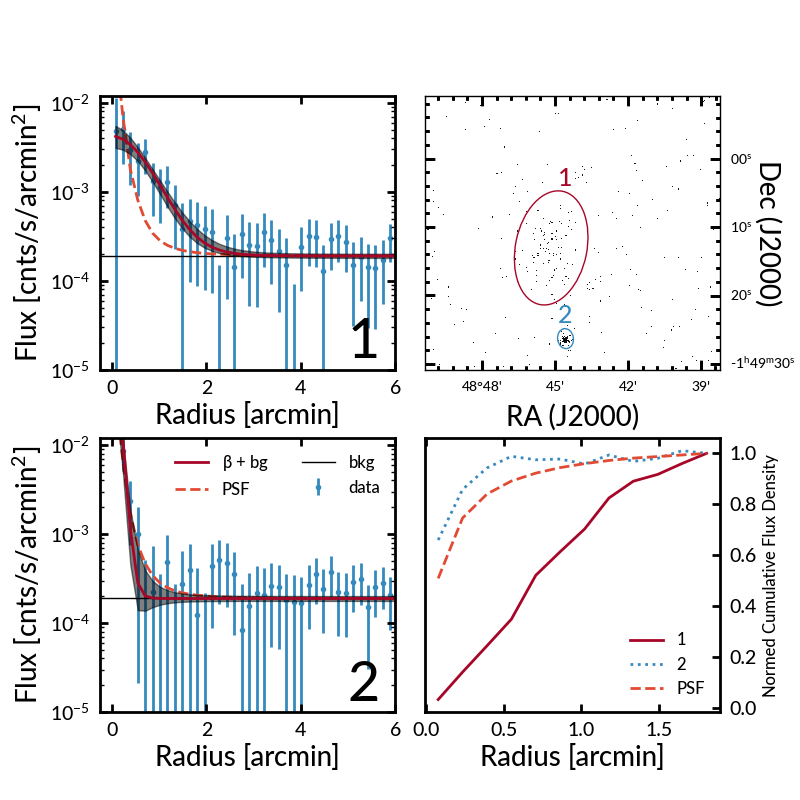

In [26]:
# f = plt.figure(1, figsize=(7 * (np.sqrt(5.) - 1.0) / 2.0, 7))
f = plt.figure(1, figsize=(8, 8))
ax1 = plt.subplot2grid((2, 2), (0, 0))                                       
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax3 = plt.subplot2grid((2, 2), (1, 1))

ax = fit_radprof(name, outpath, 1, ax=ax1)
ax = fit_radprof(name, outpath, 2, ax=ax2)

In [27]:
ax1.set_xlim(-0.25, 6)
ax2.set_xlim(-0.25, 6)

ax2.set_ylim(ax1.get_ylim())

(1e-05, 0.01191303)

In [28]:
ax1.set_xlabel('Radius [arcmin]')

Text(0.5, 391.72222222222223, 'Radius [arcmin]')

In [29]:
ax2.legend(ncol=2, loc='upper right')

In [30]:
ax1.text(5, 2e-5, "1", color='k', va='center', fontsize=40)
ax2.text(5, 2e-5, "2", color='k', va='center', fontsize=40)

Text(5, 2e-05, '2')

In [31]:
ks_test_sources(name, outpath, True, ax=ax3)

In [32]:
ax3.set_xlabel('Radius [arcmin]')
ax3.set_ylabel('Normed Cumulative Flux Density', fontsize=12)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [33]:
ax3.get_lines()[0].set_color("#A60628")
ax3.get_lines()[1].set_color('#398ABD')
ax3.get_lines()[1].set_linestyle(':')

ax3.legend()

In [34]:
def show_sources(name, outpath, fig):
    # check for files
    # check for detections
    if os.path.isfile(f'{outpath}/{name}/{name}_vtp.detect'):
        srcs = f'{outpath}/{name}/{name}_vtp.detect'
    else:
        return
    # events image
    if os.path.isfile(f'{outpath}/{name}/{name}_img_50-600.fits'):
        evnts = f'{outpath}/{name}/{name}_img_50-600.fits'
    else:
        return
    
    # check for imaging -- sdss first
    if os.path.isfile(f'{outpath}/{name}/{name}_DESstack_r.fits'):
        survey = 'DES'
        optimage = True
        img = f'{outpath}/{name}/{name}_DESstack_r.fits'
    elif os.path.isfile(f'{outpath}/{name}/{name}_DECaLSstack_r.fits'):
        survey = 'DECaLS'
        optimage = True
        img = f'{outpath}/{name}/{name}_DECaLSstack_r.fits'
    elif os.path.isfile(f'{outpath}/{name}/{name}_SDSSstack_i.fits'):
        survey = 'SDSS'
        optimage = True
        img = f'{outpath}/{name}/{name}_SDSSstack_i.fits'
    elif os.path.isfile(f'{outpath}/{name}/{name}_PS1stack_i.fits'):
        survey = 'PS1'
        optimage = True
        img = f'{outpath}/{name}/{name}_PS1stack_i.fits'
    else:
        optimage = False   
    
    # now we need to read the individual detections
    detects = Table.read(srcs, hdu=1)
    info = Table.read(f'{outpath}/{name}/{name}.info', format='ascii.fast_csv')
    
    
    # show the figure
    gc = aplpy.FITSFigure(evnts, figure=fig, subplot=(2,2,2)) 
    gc.show_grayscale(vmin=0, pmax=100, stretch='linear', interpolation='none')
    
    gc.set_theme('publication')
    
    aplpy.TickLabels(gc).set_font(size='small')
    aplpy.TickLabels(gc).set_xformat(xformat='dd:mm')
    aplpy.TickLabels(gc).set_yformat(yformat='hh:mm:ss')
    
#     gc.axis_labels.hide_x()
#     gc.axis_labels.hide_y()
    
#     gc.set_tick_labels_size('small')
    
    gc.show_regions(f'{outpath}/{name}/{name}_vtp.reg', layer='sources')

    gc.recenter(info['RA'], info['DEC'], 5/60)

    # write legend
    xo, yo = (0.5, 0.7)
    gc.add_label(xo, yo, '1', relative=True, fontsize=18, color='#A60628', 
                 horizontalalignment='right')
    xo, yo = (0.5, 0.2)
    gc.add_label(xo, yo, '2', relative=True, fontsize=18, color='#348ABD', 
                 horizontalalignment='right')
        
    return gc


In [35]:
ax4 = show_sources(name, outpath, f)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 57164.712431 from DATE-END'. [astropy.wcs.wcs]


INFO: Auto-setting vmax to  1.100e+00 [aplpy.core]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 57164.712431 from DATE-END'. [astropy.wcs.wcs]


In [36]:
ac = ax4.get_layer('sources')

In [37]:
ac.artistlist[1].set_edgecolor('#348ABD')
ac.artistlist[0].set_edgecolor('#A60628')

In [38]:
ax4.axis_labels.set_yposition('right')
ax4.tick_labels.set_yposition('right')

In [39]:
ax4.axis_labels.set_ypad(-1)
ax4.axis_labels.set_xpad(0.85)

In [40]:
plt.subplots_adjust(hspace=0.25, wspace=0.1)

In [41]:
ax4.ax.set_aspect('equal',  adjustable='datalim')

In [ ]:
plt.savefig('classification.pdf', bbox='tight')